In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False

In [3]:
import pathlib
dataset = "PlantVillage_Dataset\color"

data_dir = pathlib.Path(dataset)

print(data_dir)

PlantVillage_Dataset\color


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

54303


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

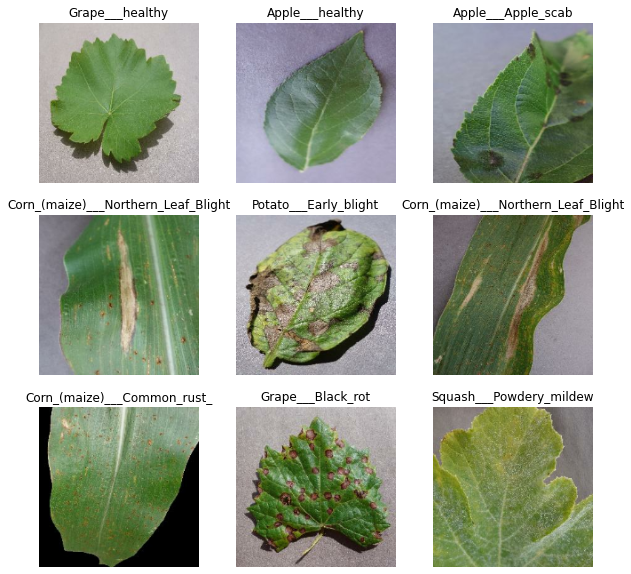

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
len(list(train_ds))

1358

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9775351


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1358/1358 [==============================] - 394s 289ms/step - loss: 1.0349 - accuracy: 0.7008 - val_loss: 0.5214 - val_accuracy: 0.8372
Epoch 2/10
1358/1358 [==============================] - 378s 278ms/step - loss: 0.3752 - accuracy: 0.8815 - val_loss: 0.3556 - val_accuracy: 0.8879
Epoch 3/10
1358/1358 [==============================] - 377s 277ms/step - loss: 0.2004 - accuracy: 0.9346 - val_loss: 0.3796 - val_accuracy: 0.8786
Epoch 4/10
1358/1358 [==============================] - 385s 283ms/step - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.3345 - val_accuracy: 0.9034
Epoch 5/10
1358/1358 [==============================] - 383s 282ms/step - loss: 0.0899 - accuracy: 0.9703 - val_loss: 0.2544 - val_accuracy: 0.9289
Epoch 6/10
1358/1358 [==============================] - 381s 281ms/step - loss: 0.0665 - accuracy: 0.9780 - val_loss: 0.3116 - val_accuracy: 0.9190
Epoch 7/10
1358/1358 [==============================] - 386s 284ms/step - loss: 0.0543 - accuracy: 0.9819 - val_

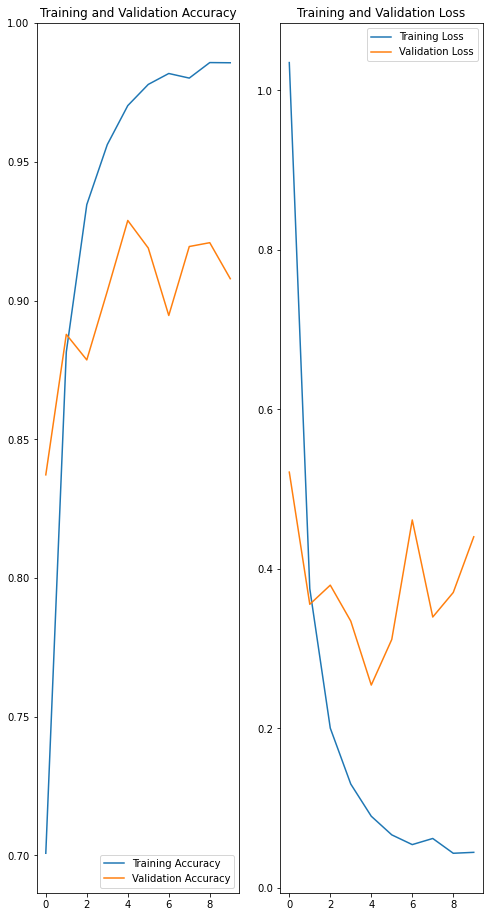

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

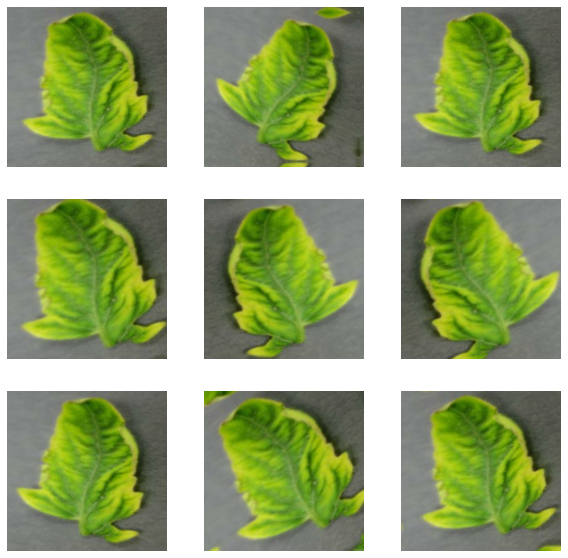

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [25]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1358/1358 [==============================] - 417s 306ms/step - loss: 1.2370 - accuracy: 0.6506 - val_loss: 0.8038 - val_accuracy: 0.7533
Epoch 2/10
1358/1358 [==============================] - 420s 309ms/step - loss: 0.5689 - accuracy: 0.8245 - val_loss: 0.5396 - val_accuracy: 0.8289
Epoch 3/10
1358/1358 [==============================] - 415s 305ms/step - loss: 0.4028 - accuracy: 0.8731 - val_loss: 0.3994 - val_accuracy: 0.8760
Epoch 4/10
1358/1358 [==============================] - 409s 301ms/step - loss: 0.3226 - accuracy: 0.8969 - val_loss: 0.3464 - val_accuracy: 0.8890
Epoch 5/10
1358/1358 [==============================] - 422s 311ms/step - loss: 0.2733 - accuracy: 0.9108 - val_loss: 0.2938 - val_accuracy: 0.9059
Epoch 6/10
1358/1358 [==============================] - 415s 306ms/step - loss: 0.2351 - accuracy: 0.9238 - val_loss: 0.2823 - val_accuracy: 0.9126
Epoch 7/10
1358/1358 [==============================] - 409s 301ms/step - loss: 0.2024 - accuracy: 0.9335 - val_

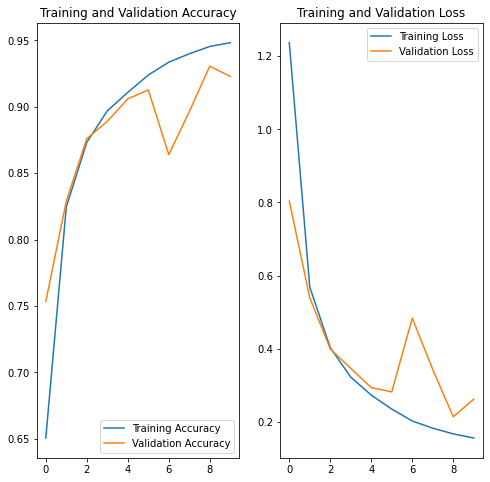

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
Plant_url = r"PlantVillage_Dataset/color/Apple___Apple_scab/0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Scab 2973.JPG"
Plant_path = tf.keras.utils.get_file('Plant', origin="data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYSFRgWFhUZGBgZHBwaHBwaHBwcGBocHR4aHBkcHhweIS4lIx4rIRoYJjgmKy8xNTU1GiU7QDs0Py40NTEBDAwMEA8QHhISHzEsJSs0NjQxNDE0NDQ0NjQ0NDQ0NDY0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAPIA0AMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABQECAwQGBwj/xAA6EAABAwIEAwYEBAYCAwEAAAABAAIRAyEEEjFBBVFhBhMicYGRMqGxwRRC0fAVI1JicuGC8QczkiT/xAAaAQEAAwEBAQAAAAAAAAAAAAAAAQIDBAUG/8QAKBEAAgIBBAIBAwUBAAAAAAAAAAECEQMEEiExQVEiQmGBE3GhsfCR/9oADAMBAAIRAxEAPwD2ZUVViqvDQXHQCT6KG6BkRc07tdS/pcRz8P6rI3tXROocPQfqsFqcT8lP1I+zoUUM3tJhzq+PMFZ6fGsO7Sq31MfVXWbG+miVKL8kkiwU8Sx12uafIhZg5aKSfRay5FSUUgqiIgCIiAIiIAiIgCIiAIiIAiIgCIiAorKgkELIqFQ1aoHkWNpGm9+QgQ4g2vYn3Cwsrgm5yk6a5D76H5KZ7RUwzEVJ3M87kA6eqhatMO3HllAPTUL55xam16Z5k1UmbAgW3Co5vvzv+q0mYl1PwvBcyQB/U3y6dFKsbPiF2mII0K12KRCZq9wSTlaPn72KyUK9YEBj3sI5OcQRroTqpBjLAAXOnPqsXdZXiRuoeJx5TJ5NpnaDEs/Nm/yDTPmP0K3cP24I/wDZSsNS0w4dcp1HqonENzzsPn7qHfhfECDYGZ+xSOXNB8N/ks8s49M9O4f2jw9eMtQAnZ1j81LgrxB7cshpgkz4t+QnRSXCu0OIw/ha/MBqHXaDyvp6Lrx65/Wv+GsNV4kj19Fy/Cu11OpDangdz1b77eq6Rjw4SCCCu/HlhkVxZ1RnGStMyoqKq0LBERAEREAREQBERAEREAREQHBdqKP/AOhx5tbGvKPsof8ADEj44HKwlT/am9bya37qJY2D4on97LxskXvlXs4Mi+bIvEYUC2d3uYKx4bE92bOzNOrTOvtr1U6+mwz4ptA5laVTCMcHTYR/39lEcckZNU7RvYZ4qDM1/hMC+o5tjYpXpwdAAJM9fPmoBlF9J2emfNpnKRyU/gqoqsmYG4Oo6dfNaxba2yLRe7gxlhDZMzyAPzK02MsZ3Ov79VI495y38LRFtyqGnDJy6df3dTKIaOexVLchWNAc3MRpblpoVIvZmJ5N16k6DyWnScS/I4+EyI56xAXNKHNmT7NQUyb6DoPpzUnwjjtTDu8DpZq5jhbqRy9ExFJoYDF4nyUZUoEaED5D3VKljlcSLcHaPVeCdoaWKENOV41adfMcwpkFeHtf3eV7TefiaYg/Zd12e7YB0MrGCbB+3QH9V6ODWKXxn37O3DqVLiXZ3CK1pm6uXedYREQBERAEREAREQBUVUQHFdqS1tcZjGZgPSQXDX2UThw1/hJAO5+8KZ7eUQG06h0BLSOhgzflB91CMrsdJIJO0Cdf35Ly5qsrX+5OHKqmyrcOXHwC3PX2WtUpOE+M/I+hC23OeGxIDTrFien2WJ9UwbWA0hGkZMjajHjV+/IX8wmHxdSm4keJs+JsQCPMbrZY2SXFpAGljrz9PutOo3NsR+9FWrKcrlEq2l3jmvzZmE87g/0nqr8fiO7blnr1Pmo3hWJ7t2Q/C+xvMcj5gpi8C/OQTHU7jmCpu+H2Wv42jNhKsMk7y6Y12/VazWhzwd5A+mi33u7toBs0fT9/VaeFeHvDusmRrqjXgh+Dfx2EgdTtvHJROIoTrppO/p1U29zAy0ZjEmZI6Dko1jM8bgOP2WeTHYkkRLsMWSI8DtTqRyP+la1hpk5rbAajz8lN4kwIao7ui90POY/lJ18ljKNOkZuNE/2a7TuokMqeKkdDqWnp06L0WjVa8BzSCDcEaFeNPyUzZxncAKe7Mcddhjlcc1J3Wcp5jl1HRden1Lg9s3x/R1YM7XxkemKqw0qoeA5pBBEgi4IWVemnZ3lURFICIiAIiIAiIgIPtZhs+HfGrYdpOmtvKVxOGa5rQ/K0A8o0NpK9Nq0w5pB0II915cc9Go+lBBa5zRa0SSDPKDK4NUtslL2cmojypG7+JGpExYC3uSVbSGaXRbT03KxPwoa3NmsADBuAdrfZadTHvafELcxost3s52/ZnqU5jKdv+1jrz+UuvbX69FrsruqP8IJ2PL1WZjHl0mN9JO3knDKXZhIIIAcSSOv75q7C44t/lv8AEzZ2rqZ5+SPYIkkzuYvv8kZUDG6TKq4r2Qm0y/FYZ2aDJbrmmcw2I6K3BBpeYEAA/p91dSxzCMj2kNmzhcsnpyWQ4c0GAyHh/wALhuOvVE0+GWryjJiquggADXaTyV2DZmGbmSR0UPia2by+vqpLDuy0x4oOt9hsPv6pYTtirQlxGu/VZCI20npoFTCHW+bzG3+1lrOsTyEepsm3hsURT6WbRgPUlabMzHFrgIKlmPy3yk/VWYpjag/uGnNYyhduyjiS/ZHjj6LhRfJpkwDuw6X6Er0UFeLPoAHO1xDhJj9F3vY7jvetFJ5hw+GdTGrfMfTyXXpM1fCT/Y7NPm+mX4OuRUCqvROwIiIAiIgCIiAouD7c4QsqNqtFnjK6OY3/APn6LvFF9oOH/iKDmD4viaeThdv6eqxzw3waM8sd0WjzU4zNDRPQXI9GysrKL3XywP7lZhMeGnxMa03B8IBDhqFlfiu8kB2Vu5+wXnRaaPO48llWs5lmgQNYG+5V9LEFoknxfT03Kw18QxtgYO0a+ZK1MRhC4Eglpva8efTyVnx0RZumsahiLazz2+6qWtBaDEDUc1oZX02GLkm5GoGvz+ypSxUby46Aj92spVEX7JM4gA5WsmNdB7rNh8RmBY9sMduJlh0BBVlBwa2wkmSf19ldTpFwmY/XqrONolNpkVi8M5lQMcLTM7EbQq4l0A6+X26KbqUy5mQnxi7Hb2uWrl3YwveQZOXY2k76rLnp9iSS59krw+pBBOht0tspDFm0aCZ9v+1G8KfmJBFhtt5ei2MW1tm3AEn9Ar/SgujLQAM/VUfREzuJuFjwWs/lW1XgXG6hpOIRG1sG10mMrtjz9NFrtxL6WhyvYczTsQDf1UpUqNIgQTEwoiqHtfmvH66hYTW12ir45R6j2b403F0g4WcIDhyPPyOymV5TwLib8NWaS7Mw+EmNRynmNQvUqNQPaHAyCJB6Fepp8u+PPaPRw5N8eezMiIug3CIiAIiIAqFVRAeZduOGdzV71rA5lX4gdA4X9J1UKcI50ZHtaIsIIj1Er1TjfDW4mk6m7e4PIi4K8kr0atN5pkXBg3gDzXlajHsnfhnn54bZX4ZtYRjabpe7M7bWBHKd1s1saXDKACToBqo93hEOeJ5geEdOcLGMSKZLQIO7jqep5D7KsZVwYXRLU2lguRmcLmdByHVYMpJDTcDnf26rS/iAcQGkRteZW2XugZRLtDuJ3+o9zyVtyYtGYPLfyiNN/ayxtxUCCwjyPr9Vmw4dcuGkRf3WR5aTpJUq67BaMZOsjLBHmOoTGUWYwZ6cNqAXadx06ocOXWNugWengQ2C0lrhoRqquEm7LJuqfRBcNrGnULHNjUAg3nlC3cXVbmcTJvAAGsfRTD8G2t48oFVoPQOMWPmuZqPyk5xdu2l+RRPwQ1S+xL8NcNYjSyyY1/jDfIeuqxcJqS0uP0sOUKx9Zud3Of8ApaeKF8G+MMImy08ew5SQJG63GA5RMm6sxDLedlDiqYZFVqgaxvhJBAuNQdl1nYXjBfmouMj4mHf+4Eed/Vc7UaQCAzM3zE26f7Ufg67qVQObLXAgidJHl7LGE3imn4JxzcJJntQRafDcY2tTa8aOAPkdx6Fbi9hNNWj1E7VlURFJIREQBERAUXF9t+Bd4O/YDmaIeG6lo0cOrb+YK7RWubNlnlxqcWmUnBSVM8XoNYBmc4vdaJERy8PNYcQ9plpvzH2BCle1/B/wlXMGnuXyQ4asJuWco3HmoWhhmM8TiXGxvbytzXlcxltkeXOLi9rLKeBEhzHloB/MLT0I19lsYvGua6MsDYjf+4q04o1HQ2zRqdGgDXyWzQcCMsZgN3CZ8twFZR9FV9jDT4hYNMT8RvpOg8t1I4euwCZv9bTbn/pRtXhjC4EOLALjfr4SFXGYR4jI0kN0Lbg85GylOuyeUTuHeQJmx6c9N1ttMrl6GLe2Gubl3Eg32+6kjjSAL77jQiFpGSaLJkqWAeIG405hR/GsF+IYarB/MaPEP6wNwOa2cNig4S6P9rPTfMOafI/ZRONq12WTVU+iC4Di/A8EQRHymVa10u3ufVSvE8K3I+oxsOMZ2jb+4BcwMUMw5bc5HI7FZb+KKSW2kzsKVwL+SsewrFgK+YDXbXWSr8Q++p2H39dAtnzGyyKh7QIUPxR7eRBnWFNBjYC1eIUQ5jumnOVjli2iGuCd7DcQOZ1FxEEZm7Gd7eV/RduvGeH4w0q1J7XQQWz1voehFl7HRqBzQRoQCPVdmjybobfR26ae6NejKiIuw6QiIgCIiAKiqiAjuL8NZiaTqbxZw13B2I6rxnjfCH0KpY4kOBvyeBo5s7nkvdlz3avs63G04sKjbtd88p6H5Ll1GHcty7Rz58O9WuzxWpiHnwhpa0aCLeZ5lSXDcWMji4QAQIO5PI/vRWYzDVqNRzHuLQ03J5eXNYXY8THxM5W2381wptHm9PklqOJzAzqdByCkGYgQOv1mIUNgaRLg5rpa4GAbPEbdehC1q2JcH3aW6EA7QbBW3hSaOroDMNbdVb3meQQ0gdB9VGUOI+F4IIGXX5CPUrBgsXlkSfM2HlZHJF9xNMoAAkMga2MDrYqlBrRdofczCVeJMytk+GBMQYnSY21W/RqMcLELRJXwSiuHqZXXaTMgjmDqCud7Q8G7v+bSuw3tq0rpWskzKrOUEOGZjviH3CzyY/qRpSkqZzHZnGtMMPxfv5qSxNfI8N5nffYXUfiuHOwldj2DPScZH/KLeazcQLXPAnQgaaddVVTTSRnzFUyXpsaRaCsWIYIIWLA1BGUm4nUrPi/gMLSk49E+CDxVKGgmAXAEecc9phem9k8X3lBoPxN8J+oXC4qhmYWkSI+m6new2J8Rb/U30lhj6E+ynTPZNL2jXA9s/wBzukRF6Z6AREQBERAEREAVCqogOc7T9m2YxpMAVACA7mOR+V9l5LiOFOw1RzX03FzdGk2PM9ecL3tRHHuBMxbYd4XD4Xj4mn7jouTNg3cx7/s5s2BT5XZ4tgcf/MEwJO9gFMU8S2ocr2gkTIdeI66rT7S8EdhqrRUaWyZztbLH3uQRodyNpUVSovLi9jmuMk+F2k7kEg7ripx4f8nntSi6Z1DsKx7HNiJMSCTobWnRaP8AB2vMZxaJ1N7z6LWwNZ9Nj85NgIGedTAMA6D9FQY8U9Zk89QOcKtqw2q5JGjwxkAFxMCJy6KSwGEawQ1ziB8vJa54lTfTzMIBJi9rxp7Bb+ExLMrIIuYI3Bgm/sFrGr7LKvBkDYHxRE3idFkoVSfzSPJX1mNjTkPmrmgEfsaLSmi5lw72Nljvhdz0afsuT4xQfhnlrrsJljiA6b/sLpjSV/dNqs7moAf6HEaHYLmnj2vcuizW5V58HMUMc3M0EgzHsbH99FOljTBMajmuQ4ngHYaoWv2kgjlsukoPDmMcDfLN9FMZcOzNN3TNyp8J9VrdmMXkxFMaS5zR1Bt9/ktprgW+ihMNUDXsfo4VR7T/ALV5OpxaLJ1JM9kVVa0yFcvWPUCIiAIiIAiIgCIiAKiqiA1MbgmVmFlRoc06gj9weq8x7T/+Pn0wamF8TdSwyXAbx/V9fNerpCznijPszyYozXJ860KvduMgmBlcCCJB1aBsba9Fd+EY67Hgf2vsR/y0I62Xs/HuyeHxgJc3K8/nZZ0jSeep1XmvFuyWIwc+HOwm9RugaOY1C4MuGUOTz8uCcPFoh34OrIDW+FuhEEHm62sq8Yl9NrWuDmnUWgE7eix0saBDXMETPIxylbuGxGV2QuiQSdwDqBfdc3Pk51Rt4zjjmsZB1+YESCPOfZSnC+MsqQJyuO2h9Fo06NLEMEmSLBwgO6Tt8lgZ2fuYqZYmA4eIRHKQRv6q6k12aJvwdW3EtsCZO36qj8rxAd/pQuG4U8SHVGnXZ89Fmbw57YLagERYTHzWu6+GjS36JLHYMYumWOtUZ8J5qAot7puRzXAhxbpNhe3upfBvqh0vLJBtB0HJZe0uFc5jazBBb8QC5JNRlx0Xcd0bXaNfNLAQZEWMazp+4UKQGtBvOckXG36kLL/EwKLiBlJmDMwTa1tVrV3mWDX4bneAFpKV0ZWj2nCGWNPQfRZlr4L/ANbP8W/QLYXtR6R6q6KoiKSQiIgCIiAIiIAiIgCIiApCoRKuRAclxnsXRrHPT/lPBmwBY7zbt5thec8a7KVsIS505P6wC5o/yI08yAvcVQhc89PGXK4Zz5NPGf2PnnDtcwy2oyx2cpKpxZ9J7Yhwyi+uYHW/nb0XpfGuw2FxMuDe6frmpw0E9W6FchxHsViaMhgZVpC/w5n5t7fENBoVyzwTjyuTjlp5x6K4Pj7KogkMfyOk7LZZxNjrEgeo9vNcliWBhg4dwGhgkSd7ROqty0Xn4nsk6GI9zBWX6kjLc0dtSxDH3aRyW3hq8HK4yx1r7Lh206TYaytBJ2FvUg2WenXqtIDajHN8+u0/ZZZJqUWmjSGRp2bPG+DllQMFmOcHAx7j0VlZ7X1GMbrLQOXjcBPPSfddXQZ+IoQ4XAgH6QoPg+DcMXSbl+J8n/FgJ9v0XNhybpKJeeOpJx6Z6vSbAA5ABXoEX0iPSKoiKQEREAREQBERAEREAREQBERAEREAVIVUQGhjOGUa3x02u6kX99VCYjsVh36Zm9JkD0K6lFnLFCXaKOEZdo8+xP8A49IOalVaD/cy3y/RRx7LYthJdSY/rTcNP8XwvUlaVhPSY5fYzemg+uDzjgtOpRfle17QdntyiemoXQ8Pwg/ENfyDh6kLoq1FrxDgCFCvBpVI9l5ebSvT5Fku1a/BpDDSruuToFVWMfIB5q5e8nasuVREUgIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIChUTxqiSGuAJgwY1j9/VSypCxzYllg4PyTF07NPhhOQSCOU6wt1UhVU4obIKN3RBVERagIiICkrXp4prnupg+NjWucINg8uDTMQZyO05LFxSiX0ntGaXNjwENf6F1p81AN4NWJLy0MdkoNblcRlyVKhfaT+R43OpAQHUvqARJAkgCdydB5qlOoHCQQQCRYzcEhw8wQR6Lk/wCE135O8pZhTbRblLwc7mOfneLwJDm63srH8BqhpawVGN7yu7+W6mHO7x7nU3gvDgMrTGgIItKA7OVYyoHTBBgkGNiNR5rm8RwmpBcA5z++LxLxkLYIbnBI8IkmGwQb30WKpwio0vy0paatR5a14b3mcHu3TNshOhjWRMIDpcTiW0wHOMAua0WJu5wa0W5khbC488HxDmua+TUL6ThXDgYa3u5Aa7dpa4wRB13IW/UwlY4dlPL42lhfDrVQ14zgOJzAvAzeL+qCdSgOglJXJ4nheIcTkaWkkFp7yzGZC00om5Lt9LzNlnwHCKlOo114FRv5iYp9w0OEE71cx+aA6UlaLuKUQ1rzVYGuJDXZhlJBgwd4KvNCBUkueHknK4iAMobkbYQDG+7jdQH4Wt3IpfhyA59UOIdSztpVHOdlb44BILWkzaCRNkB0LMdTc8sD2l4ElocMwFtvUe6p+Np5A/O3I4hodmGUknKADuS63mufxWArVXPiiaYaxzKWVzAAHhveEkOzB7gMotDdZM2wVOB4p7RlqMa1jgadKqw1XMAcwgl7arQSMroF4Bid0B0h4nRBeO9ZLPi8Q8N4vyvZP4pR8H81nj+HxDxXi3O9lAYrhNZ2drGvawvzua6oHZ3d8KhdSJJyHUiYgkC0SrqHC6zAzI17H5ic/eAtaw1C8tqNnxuILrgG51GqAnP4rQh571kMs45hDTMQeRmy2qVVtRoc0hzTcEXBC5wcOqeMd3U7rwlrO+GfOHlxex2bwtiPDInkIvNcLpvbSYKrszwLmZ3MAncgQCdyJQG8iIgCIiAIiIAiIgKFERAEKIgBQoiAKiIgKoiIAUKIgCIiAoqoiAFERAVREQBERAf/2Q==")

Plant_path = "leaf_test.jpg"

img = tf.keras.utils.load_img(
    Plant_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Apple___healthy with a 67.93 percent confidence.


In [28]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
